# Create a custom simulation for the DRC

## 1. Import required packages

In [1]:
import covasim as cv
import numpy as np

Covasim 2.0.2 (2020-02-01) — © 2021 by IDM


## 2. Define parameters and country for base model

In [3]:
pars = dict(
    pop_type = 'hybrid', # see documentation - this is a hybrid between random and a data derived model. Later, develop synthpop
    pop_size = 435e3,  # population of the DRC is 87 million. Note that when I despecify this, it goes down to 20,000 people 
    pop_scale= 200, # one agent represents 200 people 
    pop_infected = 100, # 3,615 infected as of 12th March https://www.worldometers.info/coronavirus/country/democratic-republic-of-the-congo/ 
    location = 'Democratic Republic of the Congo',
    start_day = '2020-03-01',
    end_day = '2020-06-30',
    
    verbose = 0 # means it won't print all the output 
)


# other things you can re-define in pars include n_days, beta  (As below)

## 3. Take a look at population characteristics from input data (of country (location) as defined above)

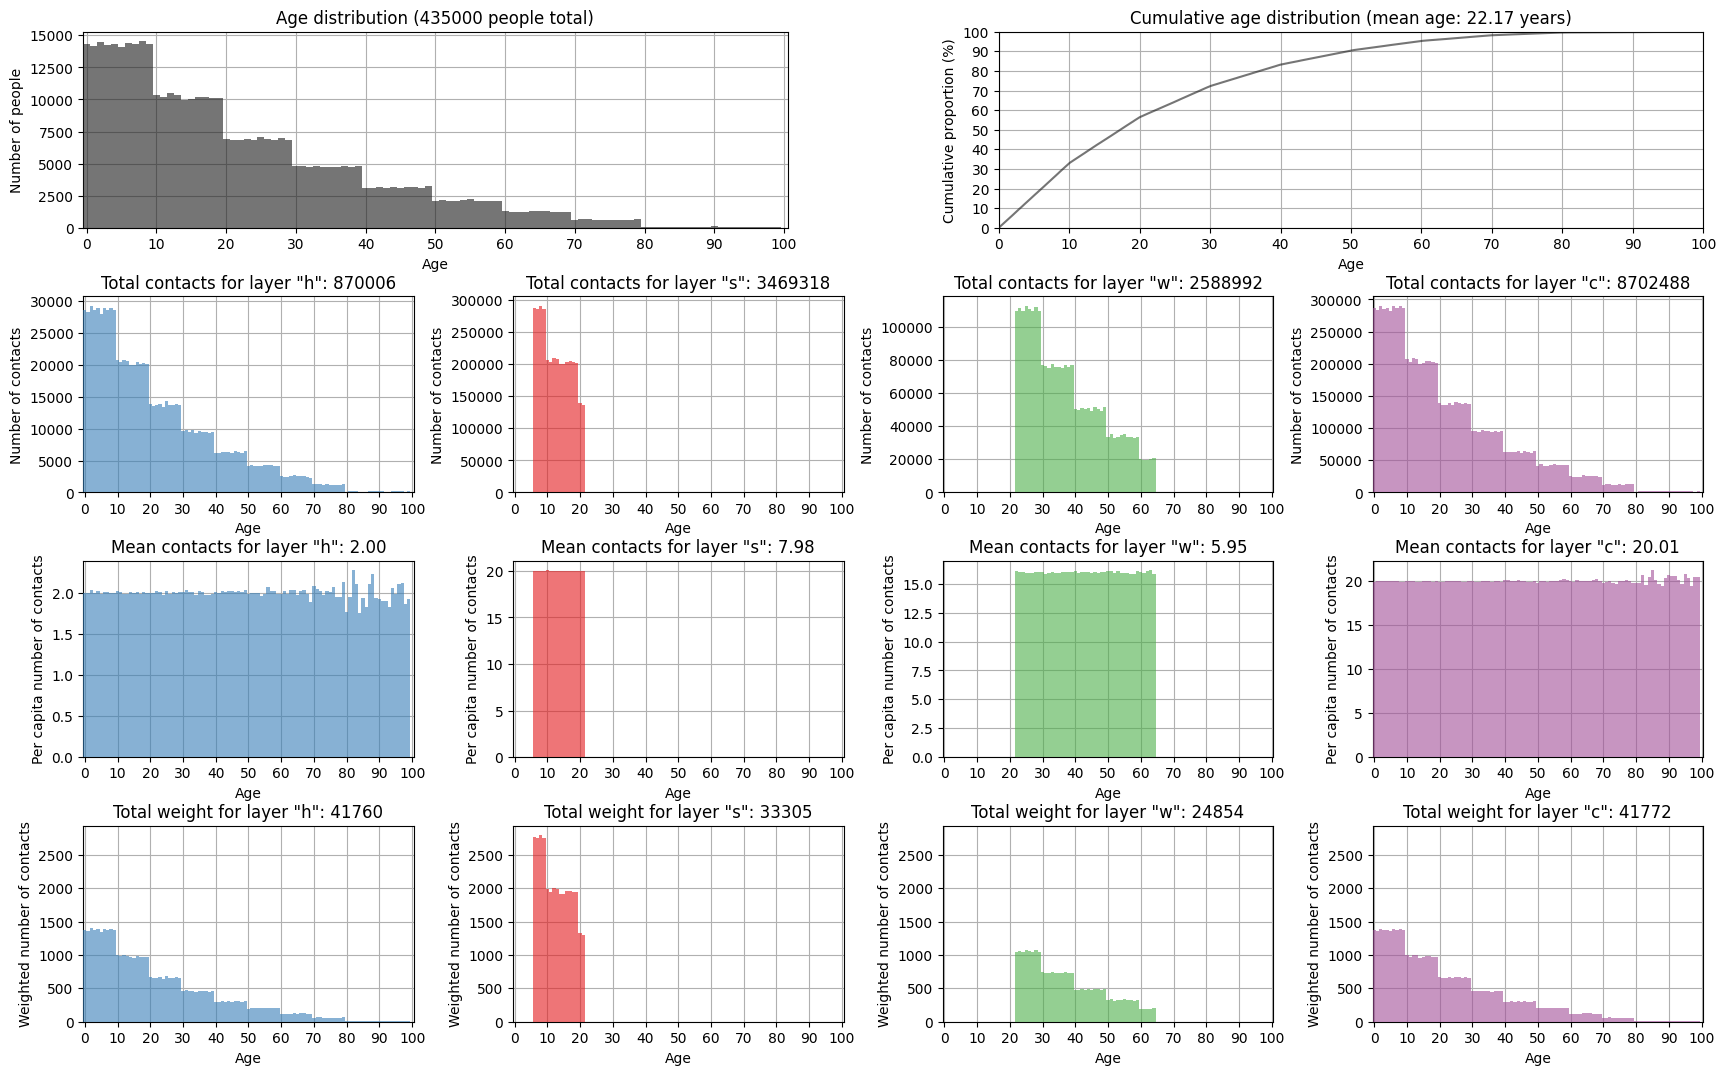

In [4]:
cv.options.set(dpi=100, show=False, close=True) #, verbose=0 # ) # put back in verbose once i've figured out what this does

# change the transmission rate (default beta value is 0.016?)
cb = cv.change_beta(days=['2020-05-15'], changes=[1.5])
sim = cv.Sim(pars, interventions=cb, label='With beta changes')

#sim = cv.Sim(pars)
sim.initialize()
fig = sim.people.plot()

## 4. Change Beta to change R0

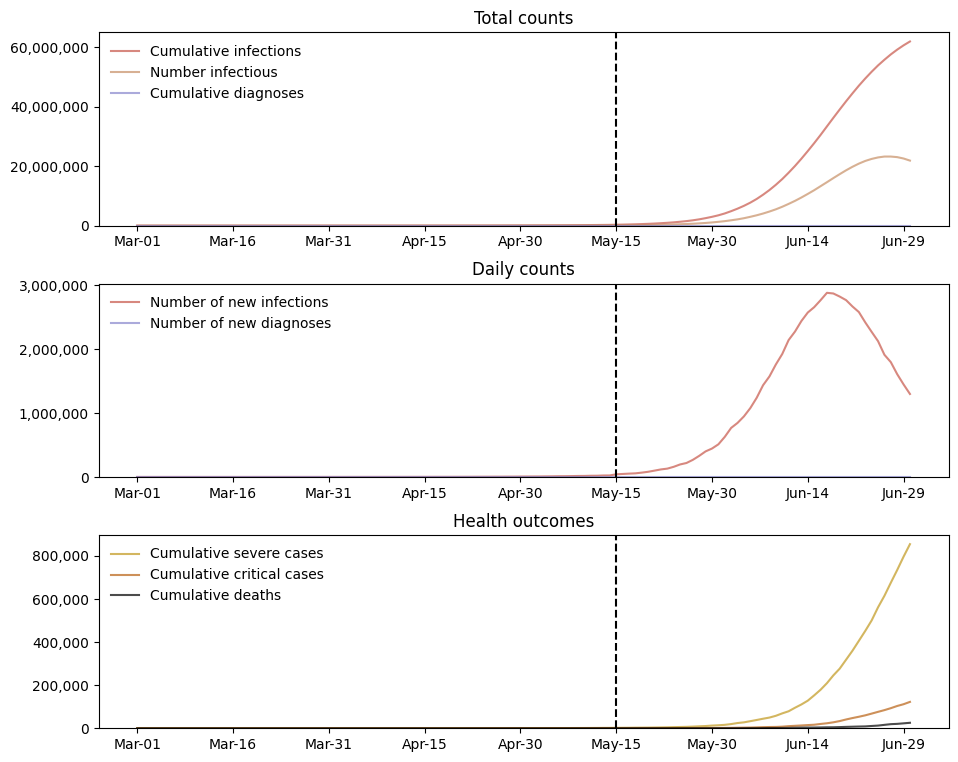

In [5]:
# just take a look at how changing beta changes the trajectory 
sim.run()
scenariofig = sim.plot()  #  this will only work if I run sim.run() not msim.run()
sim.plot()

## 4. Define comparative vaccination scenarios 

In [6]:
# Define the vaccine subtargeting
def vaccinate_by_age(sim):
    young  = cv.true(sim.people.age < 50) # cv.true() returns indices of people matching this condition, i.e. people under 50
    middle = cv.true((sim.people.age >= 50) * (sim.people.age < 75)) # Multiplication means "and" here
    old    = cv.true(sim.people.age > 75)
    inds = sim.people.uid # Everyone in the population -- equivalent to np.arange(len(sim.people))
    vals = np.ones(len(sim.people)) # Create the array
    vals[young] = 0.5 # 10% probability for people <50
    vals[middle] = 0.7 # 50% probability for people 50-75
    vals[old] = 0.9 # 90% probbaility for people >75
    output = dict(inds=inds, vals=vals)
    return output

# Define the vaccine
vaccine = cv.vaccine(days='2020-04-15', rel_sus=0.1, rel_symp=0.06, subtarget=vaccinate_by_age, )


In [7]:
def apply(sim): # this is for any vaccination
    if sim.t == sim.day('2020-04-15'): # i'm setting a situation where vaccination is introduced for all this age group on 15th
        elderly = sim.people.age >65
        sim.people.rel_sus[elderly] = 0.1 # and it reduces their chances of severe disease by 90%

## 5. Run simulation with scenarios included

In [8]:

sim2 = cv.Sim(pars, interventions=cb, label = 'With beta changes')
sim3 = cv.Sim(pars, interventions=apply, label = 'Vaccinate over 50s')
sim4 = cv.Sim(pars, interventions=vaccine, label = 'Vaccinate by age')
msim = cv.MultiSim([sim2, sim3, sim4])
msim.run()

## 6. Plot results 

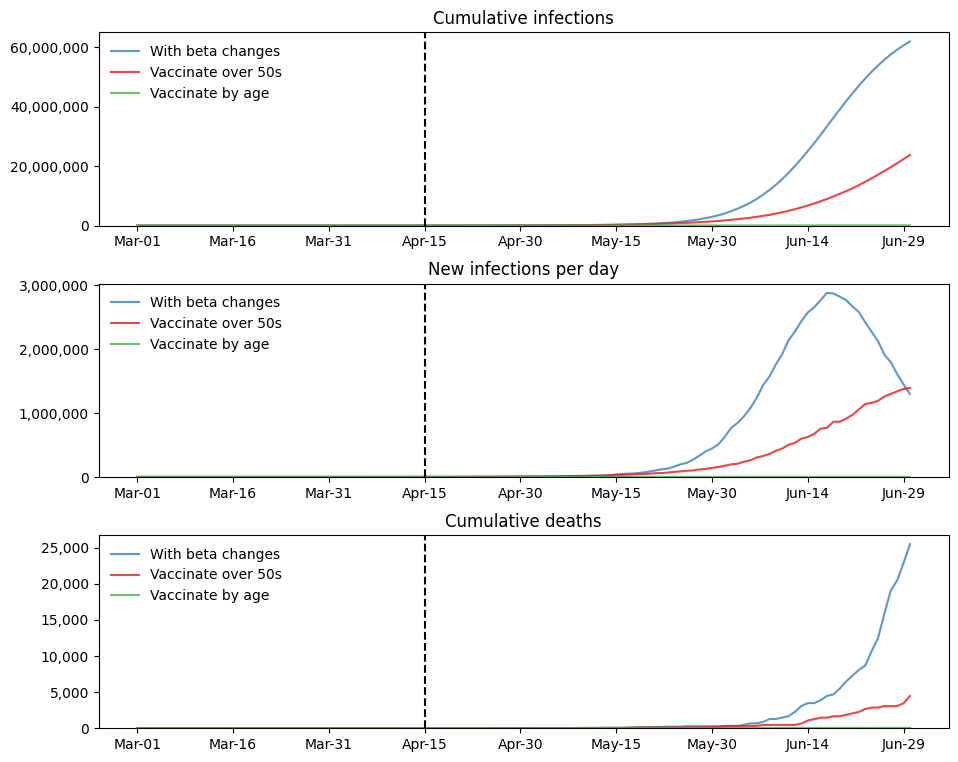

In [9]:
fig2 = msim.plot(to_plot= ['cum_deaths', 'new_infections'])
# plots different scenarios against one another
msim.plot()

## 7. Save output

In [39]:
filename = 'retro_scenarios.png'
cv.savefig(filename) # Save including version information
cv.get_png_metadata(filename) # Retrieve and print information

# for some reason this is still blank

Covasim version: 2.0.2
Covasim branch: master
Covasim hash: 5f7cf50
Covasim date: Date N/A
Covasim caller branch: master
Covasim caller hash: 5f7cf50
Covasim caller date: Date N/A
Covasim caller filename: /Users/sophie/Documents/GitHub/covasim/covasim/misc.py
Covasim current time: 2021-Mar-14 18:58:49
Covasim calling file: <ipython-input-39-e50a1d69c2dc>, line 2


<Figure size 600x400 with 0 Axes>

In [37]:
sim.save('drc-sim2.sim')
sim.to_excel('drc-sim2.xlsx')

Object saved to /Users/sophie/Documents/GitHub/covasim/docs/tutorials/drc-sim2.xlsx.
